<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Выборки" data-toc-modified-id="Выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выборки</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#Подготовка-выборки" data-toc-modified-id="Подготовка-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка выборки</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейный-модели" data-toc-modified-id="Линейный-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейный модели</a></span><ul class="toc-item"><li><span><a href="#День-недели---категориальный-признак" data-toc-modified-id="День-недели---категориальный-признак-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>День недели - категориальный признак</a></span></li><li><span><a href="#Часы,-дни-недели-и-месяцы---категориальные-признаки" data-toc-modified-id="Часы,-дни-недели-и-месяцы---категориальные-признаки-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Часы, дни недели и месяцы - категориальные признаки</a></span></li></ul></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#Gradient-Boosting" data-toc-modified-id="Gradient-Boosting-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Gradient Boosting</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итог" data-toc-modified-id="Итог-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Итог</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeRegressor

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


Данные состоят из двух столбцов. В первом столбце время сбора данных каждые 10 минут. Во второй количество заказов за эти 10 минут.

Загрузим данные снова, но заменим индексы на столбец с временем и передискретизируем данные по средним значениям каждого часа.

In [4]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Для анализа построим график временных рядом.

In [6]:
# проверим данные на монотонность 
# если время и дата расположены в хронологическом порядке, атрибут вернет значение TRUE
data.index.is_monotonic

True

In [7]:
# посмотрим на отрезок времени данных
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Данные собирались с 1 марта по 31 августа.

In [8]:
# построим график
def line_plot(data, width, height, title, xlabel, ylabel):
    fig, ax = plt.subplots(figsize=(16.5, 11.7))
    sns.lineplot(x = data.index, y=data['num_orders']);
    plt.ylabel(ylabel, fontsize=12);
    plt.xlabel(xlabel, fontsize=12);
    plt.title(title, fontsize=15);

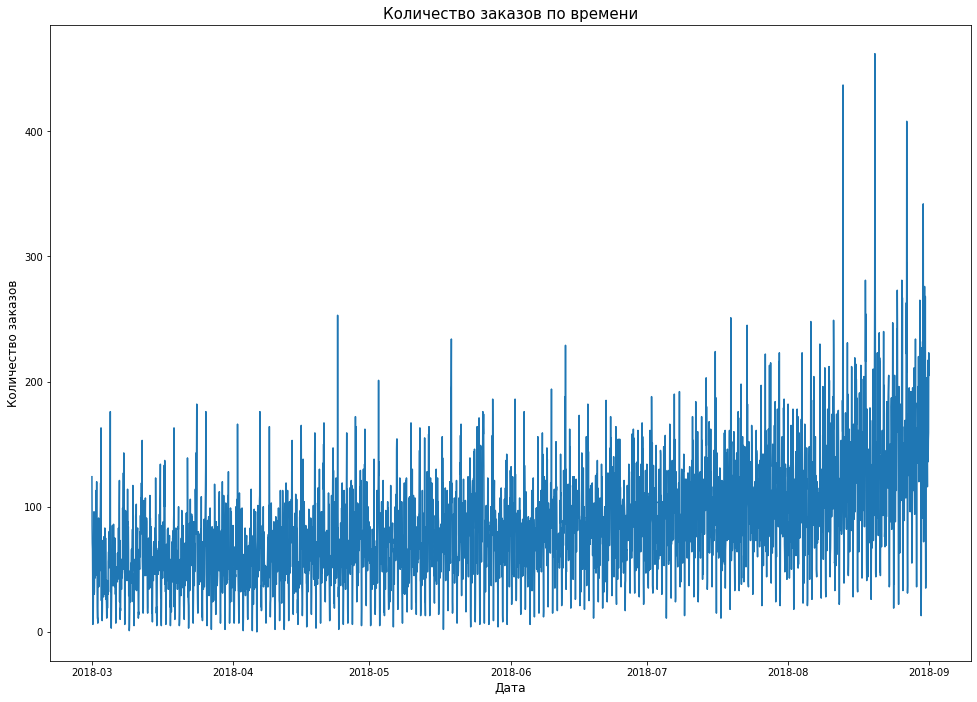

In [9]:
line_plot(data, 16.5, 11.7, 'Количество заказов по времени', 'Дата', 'Количество заказов')

Данных много из-за этого проанализировать график не получится. Для ясности разложим временной ряд на тренд и сезонную компоненту.

In [10]:
data_resampled = data.resample('1H').mean()
decomposed = seasonal_decompose(data_resampled)

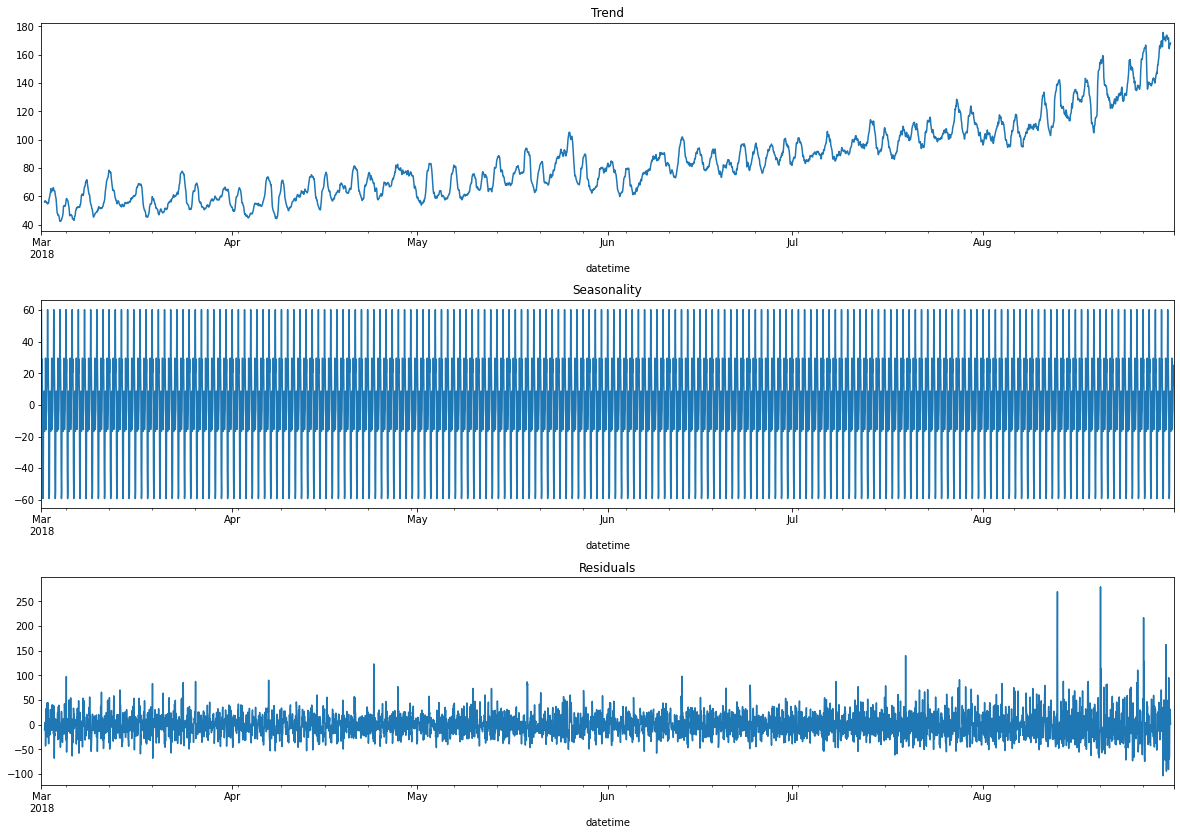

In [11]:
plt.figure(figsize=(16.5, 11.7))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Тренд связан с временем года. Весной намного меньше заказов чем летом, а в конце августа наступает пик заказов. Такой тренд, скорее всего, связан с тем, что летом у многих людей отпуск или каникулы и большинство из них предпочитает отдыхать в других городах и странах. Большая часть из них видимо возвращается в конце лета перед началом учебного года.

Временной ряд нестационарный, есть явный тренд.

Поподробнее рассмотрим сезонность по часам.

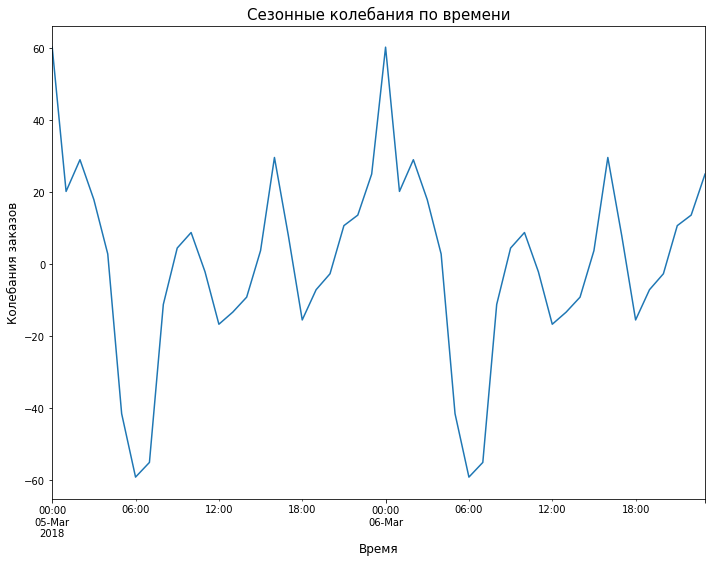

In [12]:
# начертим график заказов за два дня
# первая дата (1 марта 2018 года) это четверг, за начало графика примем дату понедельника
plt.figure(figsize=(11.7, 8.7))
decomposed.seasonal['2018-03-05':'2018-03-06'].plot(ax=plt.gca());
plt.ylabel('Колебания заказов', fontsize=12);
plt.xlabel('Время', fontsize=12);
plt.title('Сезонные колебания по времени', fontsize=15);

* меньше всего заказов такси в 6 утра;
* пиковое количество заказов - ночь.

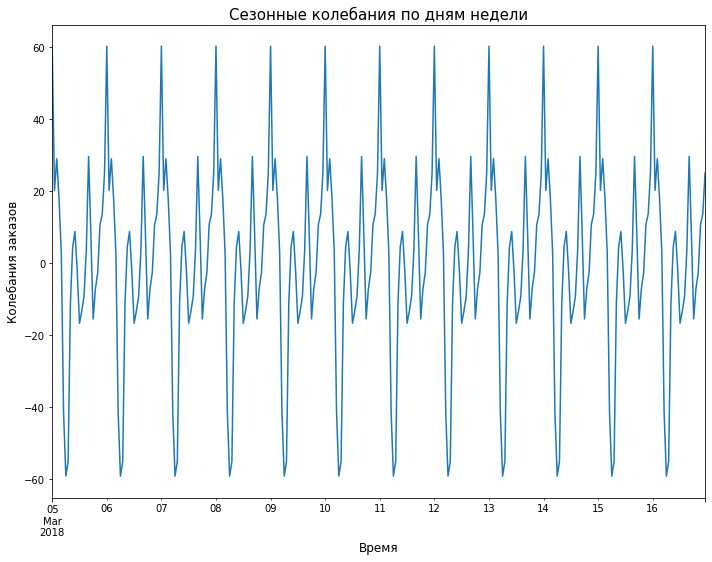

In [13]:
plt.figure(figsize=(11.7, 8.7))
decomposed.seasonal['2018-03-05':'2018-03-16'].plot(ax=plt.gca());
plt.ylabel('Колебания заказов', fontsize=12);
plt.xlabel('Время', fontsize=12);
plt.title('Сезонные колебания по дням недели', fontsize=15);

* День недели не влияет на количество заказов.

### Вывод

В ходе анализа выяснили, что временной ряд:
1. Монотонный, то есть сохранен хронологический порядок данных.
2. Нестационарный, так как имеется явный тренд по увеличению количества заказов летом.
3. Количество заказов зависит от времени дня (ночью пик заказов) и не зависит от дня недели.

Далее подготовим признаки.

## Выборки

### Подготовка признаков

Создадим признаки для горизонта прогнозирования в 1 час.

In [14]:
def make_features(data):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # вычислим отстающие значения
    for lag in range(1, 25):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(1).mean()
    df.dropna(inplace=True)
    
    return df

In [15]:
df = make_features(data)

In [16]:
#check
df.head()

,num_orders,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,0,4,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,120,3,2,1,4,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,75,3,2,2,4,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,64,3,2,3,4,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0


### Подготовка выборки

Разделим выборки на тренировочную и тестовую.

In [17]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

Так как мы работаем с веременным рядом с количеством заказов по каждому часу, воспользуемся сплиттером для временных рядов.

In [18]:
ts_cv = TimeSeriesSplit(
    n_splits=3,
    gap=48,
    max_train_size=(df.shape[0]*4)//5,
    test_size=400,
)

Проверим есть ли ошибки после деления выборки.

In [19]:
all_splits = list(ts_cv.split(X_train, y_train))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]

In [20]:
# первый сплит
X_train.iloc[test_0]

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-24 16:00:00,6,24,16,6,122.0,107.0,42.0,74.0,51.0,60.0,...,127.0,111.0,90.0,59.0,66.0,81.0,44.0,88.0,140.0,122.0
2018-06-24 17:00:00,6,24,17,6,154.0,122.0,107.0,42.0,74.0,51.0,...,64.0,127.0,111.0,90.0,59.0,66.0,81.0,44.0,88.0,154.0
2018-06-24 18:00:00,6,24,18,6,103.0,154.0,122.0,107.0,42.0,74.0,...,59.0,64.0,127.0,111.0,90.0,59.0,66.0,81.0,44.0,103.0
2018-06-24 19:00:00,6,24,19,6,51.0,103.0,154.0,122.0,107.0,42.0,...,86.0,59.0,64.0,127.0,111.0,90.0,59.0,66.0,81.0,51.0
2018-06-24 20:00:00,6,24,20,6,96.0,51.0,103.0,154.0,122.0,107.0,...,164.0,86.0,59.0,64.0,127.0,111.0,90.0,59.0,66.0,96.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-11 03:00:00,7,11,3,2,152.0,84.0,172.0,94.0,137.0,115.0,...,98.0,103.0,132.0,68.0,53.0,37.0,56.0,113.0,104.0,152.0
2018-07-11 04:00:00,7,11,4,2,117.0,152.0,84.0,172.0,94.0,137.0,...,72.0,98.0,103.0,132.0,68.0,53.0,37.0,56.0,113.0,117.0
2018-07-11 05:00:00,7,11,5,2,153.0,117.0,152.0,84.0,172.0,94.0,...,77.0,72.0,98.0,103.0,132.0,68.0,53.0,37.0,56.0,153.0


In [21]:
# первый сплит
X_train.iloc[train_0]

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,2,0,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,3,2,1,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,3,2,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,3,2,3,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-06-22 11:00:00,6,22,11,4,127.0,114.0,73.0,34.0,24.0,38.0,...,40.0,81.0,100.0,92.0,55.0,32.0,50.0,82.0,78.0,127.0
2018-06-22 12:00:00,6,22,12,4,69.0,127.0,114.0,73.0,34.0,24.0,...,66.0,40.0,81.0,100.0,92.0,55.0,32.0,50.0,82.0,69.0
2018-06-22 13:00:00,6,22,13,4,57.0,69.0,127.0,114.0,73.0,34.0,...,92.0,66.0,40.0,81.0,100.0,92.0,55.0,32.0,50.0,57.0


In [22]:
# последний сплит
train_2, test_2 = all_splits[2]
X_train.iloc[test_2]

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-28 00:00:00,7,28,0,5,122.0,213.0,133.0,131.0,86.0,76.0,...,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,222.0,122.0
2018-07-28 01:00:00,7,28,1,5,192.0,122.0,213.0,133.0,131.0,86.0,...,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,108.0,192.0
2018-07-28 02:00:00,7,28,2,5,195.0,192.0,122.0,213.0,133.0,131.0,...,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,161.0,195.0
2018-07-28 03:00:00,7,28,3,5,145.0,195.0,192.0,122.0,213.0,133.0,...,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,131.0,145.0
2018-07-28 04:00:00,7,28,4,5,132.0,145.0,195.0,192.0,122.0,213.0,...,118.0,110.0,149.0,139.0,89.0,44.0,78.0,64.0,109.0,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 11:00:00,8,13,11,0,156.0,137.0,91.0,39.0,66.0,83.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,156.0
2018-08-13 12:00:00,8,13,12,0,144.0,156.0,137.0,91.0,39.0,66.0,...,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,144.0
2018-08-13 13:00:00,8,13,13,0,92.0,144.0,156.0,137.0,91.0,39.0,...,135.0,98.0,82.0,78.0,115.0,153.0,149.0,104.0,120.0,92.0


In [23]:
X_train.iloc[train_2]

,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,2,0,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.0
2018-03-02 01:00:00,3,2,1,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,90.0
2018-03-02 02:00:00,3,2,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,120.0
2018-03-02 03:00:00,3,2,3,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,75.0
2018-03-02 04:00:00,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25 19:00:00,7,25,19,2,68.0,121.0,134.0,119.0,95.0,99.0,...,142.0,145.0,74.0,161.0,110.0,73.0,113.0,82.0,81.0,68.0
2018-07-25 20:00:00,7,25,20,2,137.0,68.0,121.0,134.0,119.0,95.0,...,124.0,142.0,145.0,74.0,161.0,110.0,73.0,113.0,82.0,137.0
2018-07-25 21:00:00,7,25,21,2,111.0,137.0,68.0,121.0,134.0,119.0,...,69.0,124.0,142.0,145.0,74.0,161.0,110.0,73.0,113.0,111.0


Выборки готовы для обучения.

## Обучение

In [24]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_root_mean_squared_error"],
        n_jobs=-1
    )
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    return rmse.mean()

### Линейный модели

Качество линейных моделей будет зависит от кодировки данных. Возьмем одну линейную модель RidgeCV с встроенной кросс-валидацией. Закодируем признаки различными способами и сверим метрику RMSE.

#### День недели - категориальный признак

In [25]:
# закодируем категориальный признак день недели
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)
categorical_columns = ['dayofweek']

In [26]:
linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ohe, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

In [27]:
rmse_lin_week = evaluate(linear_pipeline, X_train, y_train, cv=ts_cv)
print(f"RMSE линейной модели с закодированными днями недели: {rmse_lin_week:.3f}")

RMSE линейной модели с закодированными днями недели: 30.271


####  Часы, дни недели и месяцы - категориальные признаки

In [28]:
ohe_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ohe, categorical_columns),
            ("one_hot_time", ohe, ["hour", "month", "day"]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)



In [29]:
rmse_lin_time = evaluate(ohe_linear_pipeline, X_train, y_train, cv=ts_cv)
print(f"RMSE линейной модели с закодированным временем: {rmse_lin_time:.3f}")

RMSE линейной модели с закодированным временем: 31.637


### Decision tree

In [30]:
# оптимизируем гиперпараметры
FIT_PARAMS = {
    'max_depth': range(2, 21),
    'min_samples_leaf': range(1, 6),
    'min_samples_split': range(2, 6)   
}

dtr = DecisionTreeRegressor(random_state=42)

In [31]:
search = RandomizedSearchCV(dtr, FIT_PARAMS, scoring='neg_mean_absolute_error', n_jobs=-1, cv=ts_cv)
dtr_result = search.fit(X_train, y_train)
best_params = dtr_result.best_params_
dtr_rmse = -dtr_result.best_score_
print(f'Значение RMSE решающего дерева: {dtr_rmse:.3f}')

Значение RMSE решающего дерева: 24.668


### Gradient Boosting 

In [32]:
# выберем гиперпараметры для оптимизации
FIT_PARAMS = {
    "n_estimators": range(100, 501, 25),
    "max_depth": range(2, 21),
    "min_samples_split": range(2, 6),
    "learning_rate": [0.1, 0.2, 0.3] 
}

In [33]:
%%time
gbr = GradientBoostingRegressor(random_state=42)
search = RandomizedSearchCV(gbr, FIT_PARAMS, scoring='neg_mean_absolute_error', n_jobs=-1, cv=ts_cv)
gbr_result = search.fit(X_train, y_train)
best_params_gbr = gbr_result.best_params_
gbr_rmse = -gbr_result.best_score_
print(f'Значение RMSE решающего дерева: {gbr_rmse:.3f}')

Значение RMSE решающего дерева: 21.454
CPU times: user 4min 7s, sys: 327 ms, total: 4min 8s
Wall time: 4min 8s


### Вывод 

In [34]:
data_metrics = {'Classifier': ['RidgeCV OHE weekday', 'RidgeCV OHE time', 'Decision Tree', 'Gradient Boostring'],
                 'RMSE': [rmse_lin_week, rmse_lin_time, dtr_rmse, gbr_rmse]
    }
df = pd.DataFrame(data=data_metrics)

In [35]:
df

,Classifier,RMSE
0,RidgeCV OHE weekday,30.270534
1,RidgeCV OHE time,31.637121
2,Decision Tree,24.667609
3,Gradient Boostring,21.453797


Лучшее значение метрики показала модель Gradient Boosting

## Тестирование

In [36]:
gbr_test = GradientBoostingRegressor(**gbr_result.best_params_, random_state=42)
gbr_test.fit(X_train, y_train)
y_pred  = gbr_test.predict(X_test)
print('Значение метрики на тестовой выборке:', mean_squared_error(y_test, y_pred, squared=False).round(3))

Значение метрики на тестовой выборке: 42.912


На тесте получили требуемое значение метрики. Сравним предсказанные значения модели и реальные на графике.

Сравним выборки TimeSeriesSplit, а потом тестовую выборку. Для этого напишем функцию с обучением модели и предсказанием. Так как колебания в заказах происходят в течение суток рассмотрим промежуток в 24 часа.

In [37]:
def gbr(X_train, y_train, X_test, y_test):
    gbr_test.fit(X_train, y_train)
    gbr_test_pred = gbr_test.predict(X_test)
    
    last_hours = slice(-24, None) # сезонность в сутках
    fig, ax = plt.subplots(figsize=(12, 4))
    fig.suptitle("Предсказания Gradient Boosting")
    ax.plot(y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Реальные значения",
    color="black",)
    ax.plot(gbr_test_pred[last_hours], "x-", label="предсказания Gradient Boosting")
    _ = ax.legend()

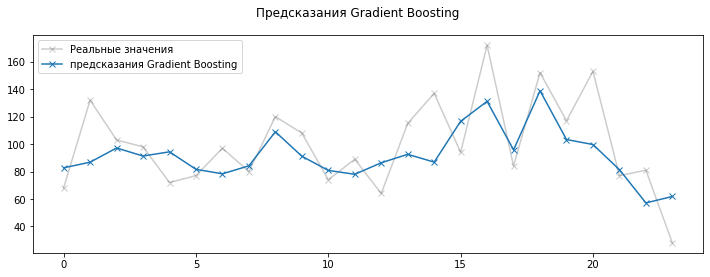

In [38]:
gbr(X_train.iloc[train_0], y_train.iloc[train_0], X_train.iloc[test_0], y_train.iloc[test_0])

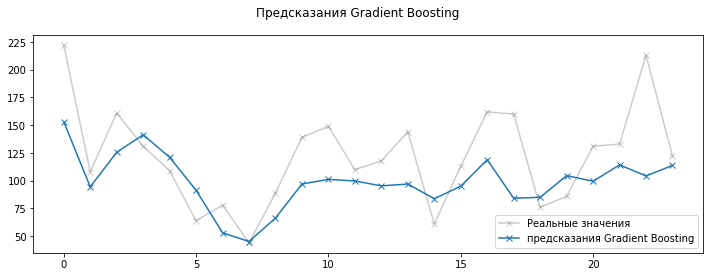

In [39]:
gbr(X_train.iloc[train_1], y_train.iloc[train_1], X_train.iloc[test_1], y_train.iloc[test_1])

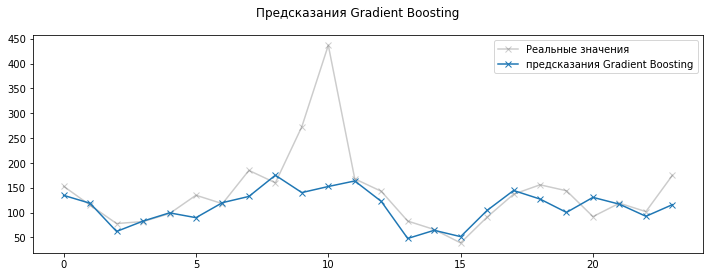

In [40]:
gbr(X_train.iloc[train_2], y_train.iloc[train_2], X_train.iloc[test_2], y_train.iloc[test_2])

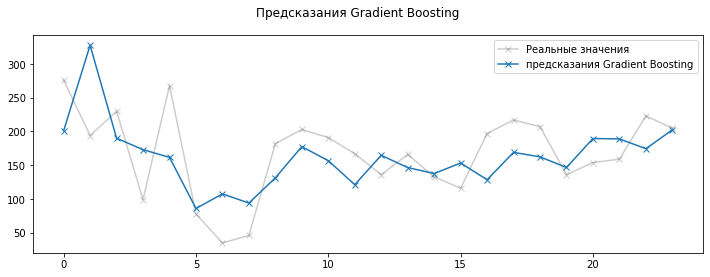

In [41]:
gbr(X_train, y_train, X_test, y_test)

Метрика удовлетворяет требованиям, хотя и заметны ошибочные предсказания. Чтобы улучшить метрику можно проделать следующие шаги:
1. Улучшить подбор гиперпараметров для модели.
2. Ввести новую категориальную переменную, которая обозначает выходной ли день или рабочий.
3. Ввести новую категориальную переменную, которая обозначает праздничный ли день или нет.
4. Если были рекламные кампании, то необходимо учесть и их влияние.
5. Промокоды, скидки в определенное время и т.д.

## Итог

В ходе исследования проанализировали предоставленные данные количества заказаов такси в аэропортах с 1 марта по 31 августа 2018 года. Временной ряд нестационарный, что усложняет задачу предсказывания. Проанализировали тренд и сезонность. Количество заказов каждый месяц возрастало и в агусте достигло пика. Количество заказов так же зависило от времени суток (ночью пик заказов). Разделили выборки с помощью `TimeSeriesSplit` и три модели:

1. RidgeCV.
2. Decision Tree.
3. Gradient Boosting.

Для модели `RidgeCV` приготовили две выборки с разным кодированием "категориальных переменных". Для первого случая учитывали, что только день недели является категориальным, для второго, что месяц, день недели, день и время являются категориальными. Во втором случае RMSE результат лучше, чем в первом.

Для моделей `Decision tree` и `Gradient Boosting` воспользовались инструментом RandomizedSearchCV и подобрали оптимальные гиперпараметры. 

Лучший результат на тренировочной выборке у `Gradient Boosting`. На тестовой значение метрики RMSE = 41.89.